# Dataset 0

Ideal settings to find baseline performance


## Document Images
- Documents: SQUAD v2 {train and test}
- Document Images: fixed font {style, size, color} line space, word space, background

## Train/Test Sampling
- Triplets = [(document-content, query-word, feature-location)]
- For each document in train/test set
    - Split content into words by whitespace
    - A fixed % of unique words are picked uniformly
    - An instance of word is picked uniformly
    - Add to triplets

In [1]:
DATA_DIR = "../data/"

In [2]:
%matplotlib inline

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from matplotlib.pyplot import imshow
from glob import glob
from collections import defaultdict
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import textwrap
import json
import re
import os

# Image Utils

In [4]:
def show_bounding_box(img, annotation, spread=0, color="red"):
    x, y, w, h = annotation
    x -= spread
    y -= spread
    w += 2 * spread
    h += 2 * spread
    new = img.copy().convert("RGB")
    draw = ImageDraw.Draw(new)
    draw.rectangle((x, y, x + w, y + h), outline=color)
    return new


def expand_image(img, new_h, new_w, bg_color="black"):
    left = (new_w - img.width) // 2
    right = (new_w - img.width) - left
    top = (new_h - img.height) // 2
    bottom = (new_h - img.height) - top
    img = add_margin(img, top, right, bottom, left, bg_color)
    return img, left, top


def create_image(
    sentence, 
    font_file, 
    font_size=12, 
    bg_color="black", 
    fg_color="white", 
    img_width=None, 
    img_height=None
):
    font = ImageFont.truetype(font_file, font_size)
    w, h = font.getsize(sentence)
    if img_width is not None:
        w = img_width
    if img_height is not None:
        h = img_height
    img = Image.new("1", (w, h), color=bg_color)
    draw = ImageDraw.Draw(img)
    draw.text((0,0), sentence, font=font, fill=fg_color)
    return img


def stack_images(images, line_space=0, bg_color="black"):
    w = max(i.width for i in images)
    h = sum(i.height for i in images) + (line_space * (len(images)-1))
    stacked = Image.new("1", (w, h), color=bg_color)
    start = 0
    for i, img in enumerate(images):
        stacked.paste(img, (0, start))
        start += img.height + line_space
    return stacked


def append_images(images, word_space=0, bg_color="black"):
    w = sum(i.width  for i in images) + ((len(images) - 1) * word_space)
    h = max(i.height for i in images)
    appended = Image.new("1", (w, h), color=bg_color)
    start = 0
    for i, img in enumerate(images):
        appended.paste(img, (start, 0))
        start += img.width + word_space
    return appended


def add_margin(image, top=0, right=0, bottom=0, left=0, bg_color="black"):
    w = image.width + right + left
    h = image.height + top + bottom
    enlarged = Image.new(image.mode, (w, h), bg_color)
    enlarged.paste(image, (left, top))
    return enlarged


def doc_to_image(
    doc,
    sentence_iterator,
    word_iterator,
    font_file, 
    font_size=12,
    bg_color="black",
    fg_color="white",
    margin=0,
    line_space=0,
    word_space=0,
    whitespace_ann=False,
):
    annotations = defaultdict(list) # token -> [(x, y, w, h), ... ]
    images = []
    cursor_y = margin
    for sentence in sentence_iterator(doc):
        cursor_x = margin
        sentence_images = []
        for token in word_iterator(sentence):
            token_img = create_image(token, font_file, font_size, bg_color, fg_color)
            if token.strip() or whitespace_ann:
                annotations[token].append((cursor_x, cursor_y, token_img.width, token_img.height))
            sentence_images.append(token_img)
            cursor_x += token_img.width + word_space
        appended = append_images(sentence_images, word_space, bg_color)
        images.append(appended)
        cursor_y += appended.height + line_space
    x = stack_images(images, line_space, bg_color)
    x = add_margin(x, margin, margin, margin, margin, bg_color)
    return x, dict(annotations)

# Document Utils

In [5]:
def alnum_parser(s, lower):
    # sentence -> sentence
    # remove anything including whitespace but 0-9 and a-z, A-Z
    # have uniform whitespace b/w words
    filtered = [ch if ch.isalnum() else " " for ch in s]
    s = "".join(filtered)
    s = " ".join(s.split())
    if lower:
        s = s.lower()
    return s


def whitespaced_split(s):
    # sentence -> list of words
    # preserve white space in splitting sentence
    return re.split(r'(\s+)', s)

# Document Dataset Readers

In [6]:
class SquadDocuments(object):
    
    def __init__(self, filename):
        self.ds = {}
        self.keys = []
        with open(filename) as fp:
            data = json.load(fp)
        for idx, item in enumerate(data["data"]):
            title = item["title"]
            for idy, para in enumerate(item["paragraphs"]):
                context = para["context"]
                key = f"{title}__{idx}__{idy}"
                self.ds[key] = context
                self.keys.append(key)

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        return {"id": key, "text": self.ds[key]}

# Generate...

In [7]:
# read datasets
train_docs = SquadDocuments(os.path.join(DATA_DIR, "squad", "train-v2.0.json"))
dev_docs = SquadDocuments(os.path.join(DATA_DIR, "squad", "dev-v2.0.json"))

print("Num of documents: ", len(train_docs), len(dev_docs))
train_docs[0]

Num of documents:  19035 1204


{'id': 'Beyoncé__0__0',
 'text': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'}

In [8]:
# document image settings
img_conf = dict(
    font_file=os.path.join(DATA_DIR, "fonts/apache/opensans/OpenSans-Regular.ttf"),
    font_size=14,
    margin=20,
    line_space=5,
    word_space=2,
    bg_color="black",
    fg_color="white",
    sentence_iterator=textwrap.wrap,
    word_iterator=whitespaced_split,
)

img, ann = doc_to_image(alnum_parser(train_docs[0]["text"], lower=True), **img_conf)

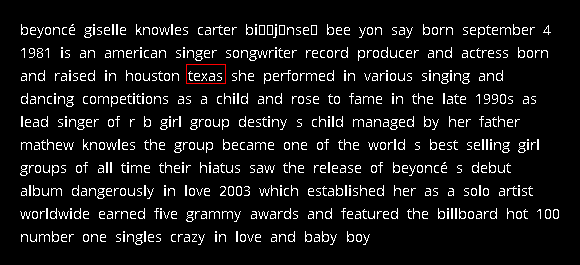

In [9]:
show_bounding_box(img, ann["texas"][0], spread=2)

In [14]:
# save images and annotations
def worker(item, outdir, img_conf):
    img, ann = doc_to_image(alnum_parser(item["text"], lower=True), **img_conf)
    img.save(os.path.join(outdir, "images", item["id"] + ".png"))
    with open(os.path.join(outdir, "features", item["id"] + ".json"), "w", encoding="utf8") as fp:
        json.dump(ann, fp, indent=2, ensure_ascii=False)
    return filename

        
def create_image_docs(docs, outdir, max_workers, worker_kw):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures_to_id = {executor.submit(worker, item, outdir, worker_kw): item["id"] for item in docs}
        for future in tqdm(as_completed(futures_to_id), total=len(futures_to_id)):
            doc_id = futures_to_id[future]
            output = future.result()

In [15]:
os.makedirs(os.path.join(DATA_DIR, "squad/v0_dev"), exist_ok=True)
os.makedirs(os.path.join(DATA_DIR, "squad/v0_dev/images"), exist_ok=True)
os.makedirs(os.path.join(DATA_DIR, "squad/v0_dev/features"), exist_ok=True)

create_image_docs(
    dev_docs,
    outdir=os.path.join(DATA_DIR, "squad/v0_dev/"),
    max_workers=10,
    worker_kw=img_conf
)

In [16]:
os.makedirs(os.path.join(DATA_DIR, "squad/v0_train"), exist_ok=True)
os.makedirs(os.path.join(DATA_DIR, "squad/v0_train/images"), exist_ok=True)
os.makedirs(os.path.join(DATA_DIR, "squad/v0_train/features"), exist_ok=True)

create_image_docs(
    train_docs,
    outdir=os.path.join(DATA_DIR, "squad/v0_train/"),
    max_workers=10,
    worker_kw=img_conf
)

# Image Dim Equalize 

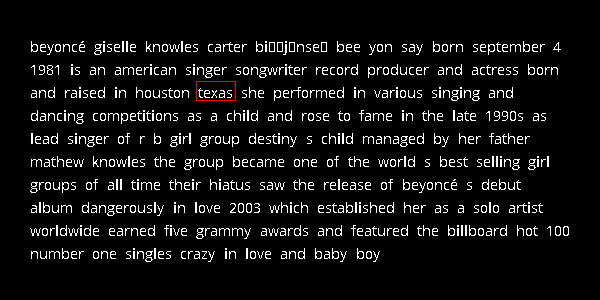

In [19]:
img_ex, offset_x, offset_y = expand_image(img, 300, 600, "black")

cursor_x, cursor_y, w, h = ann["texas"][0]
cursor_x += offset_x
cursor_y += offset_y

show_bounding_box(img_ex, (cursor_x, cursor_y, w, h), spread=2)

In [52]:
def equalize_images(image_items, feature_indent=2):
    # image_items = [{in_image, in_features, out_image, out_features, bg_color}]
    # get max sizes
    max_h = -float("inf")
    max_w = -float("inf")
    for item in image_items:
        im = Image.open(item["in_image"])
        max_h = max(max_h, im.height)
        max_w = max(max_w, im.width)
        
    print("H: ", max_h)
    print("W: ", max_w)
    print("Processing: ", len(image_items))

    for item in tqdm(image_items):
        im = Image.open(item["in_image"])
        if im.height != max_h or im.width != max_w:
            # expand image
            im, offset_x, offset_y = expand_image(im, max_h, max_w, item["bg_color"])
            im.save(item["out_image"])
            # offset feature positions
            with open(item["in_features"], encoding="utf8") as fp:
                features = json.load(fp)
            for key, bb_list in features.items():
                for bb in bb_list:
                    bb[0] += offset_x
                    bb[1] += offset_y
            with open(item["out_features"], "w", encoding="utf8") as fp:
                json.dump(features, fp, indent=feature_indent, ensure_ascii=False)

In [53]:
image_items = []
features_dir = os.path.join(DATA_DIR, "squad/v0_train/features/")
images_dir = os.path.join(DATA_DIR, "squad/v0_train/images/")

out_features_dir = os.path.join(DATA_DIR, "squad/v0_train/out_features/")
out_images_dir = os.path.join(DATA_DIR, "squad/v0_train/out_images/")

os.makedirs(out_features_dir, exist_ok=True)
os.makedirs(out_images_dir, exist_ok=True)

for doc in train_docs:
    item = {
        "in_image": os.path.join(images_dir, doc["id"] + ".png"),
        "in_features": os.path.join(features_dir, doc["id"] + ".json"),
        "out_image": os.path.join(out_images_dir, doc["id"] + ".png"),
        "out_features": os.path.join(out_features_dir, doc["id"] + ".json"),
        "bg_color": "black",
    }
    image_items.append(item)

equalize_images(image_items, feature_indent=2)

H:  1248
W:  636
Processing:  19035


In [55]:
image_items = []
features_dir = os.path.join(DATA_DIR, "squad/v0_dev/features/")
images_dir = os.path.join(DATA_DIR, "squad/v0_dev/images/")

out_features_dir = os.path.join(DATA_DIR, "squad/v0_dev/out_features/")
out_images_dir = os.path.join(DATA_DIR, "squad/v0_dev/out_images/")

os.makedirs(out_features_dir, exist_ok=True)
os.makedirs(out_images_dir, exist_ok=True)

for doc in dev_docs:
    item = {
        "in_image": os.path.join(images_dir, doc["id"] + ".png"),
        "in_features": os.path.join(features_dir, doc["id"] + ".json"),
        "out_image": os.path.join(out_images_dir, doc["id"] + ".png"),
        "out_features": os.path.join(out_features_dir, doc["id"] + ".json"),
        "bg_color": "black",
    }
    image_items.append(item)

equalize_images(image_items, feature_indent=2)

H:  1386
W:  612
Processing:  1204


In [57]:
for doc in dev_docs:
    im = Image.open(os.path.join(images_dir, doc["id"] + ".png"))
    if im.height > 1000:
        print(doc)
        break

{'id': 'European_Union_law__9__30', 'text': 'Free movement of goods within the European Union is achieved by a customs union, and the principle of non-discrimination. The EU manages imports from non-member states, duties between member states are prohibited, and imports circulate freely. In addition under the Treaty on the Functioning of the European Union article 34, ‘Quantitative restrictions on imports and all measures having equivalent effect shall be prohibited between Member States’. In Procureur du Roi v Dassonville the Court of Justice held that this rule meant all "trading rules" that are "enacted by Member States" which could hinder trade "directly or indirectly, actually or potentially" would be caught by article 34. This meant that a Belgian law requiring Scotch whisky imports to have a certificate of origin was unlikely to be lawful. It discriminated against parallel importers like Mr Dassonville, who could not get certificates from authorities in France, where they bought

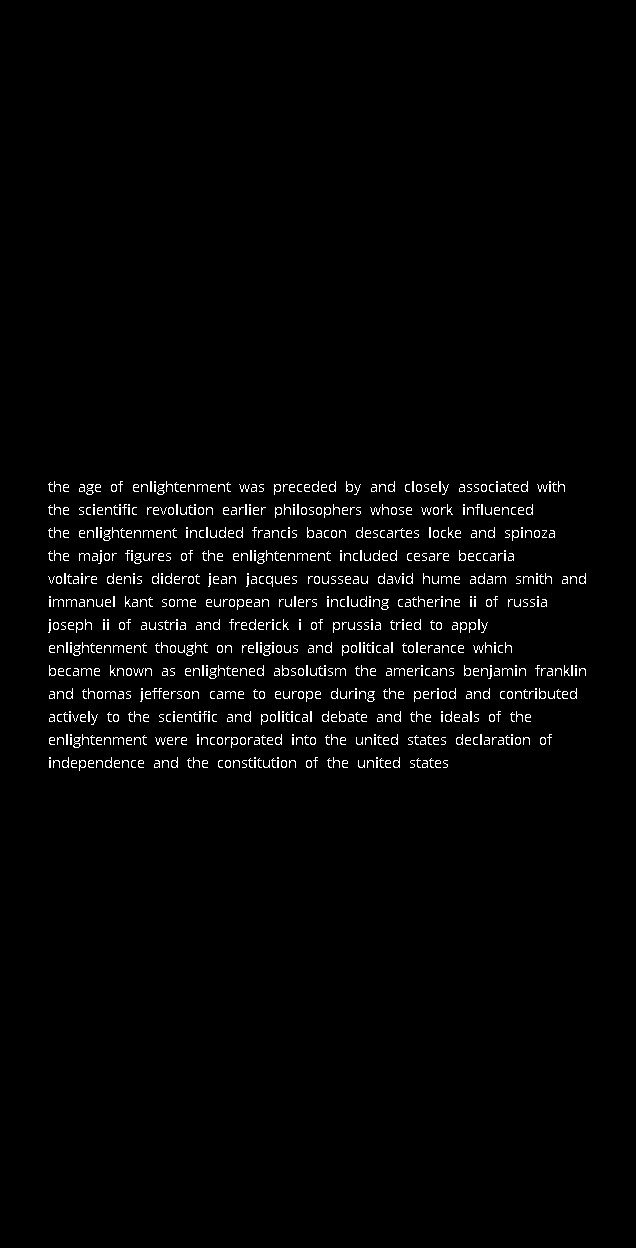

In [46]:
img = Image.open(DATA_DIR + "squad/v0_train/out_images/Age_of_Enlightenment__161__19.png")
with open(DATA_DIR + "squad/v0_train/out_features/Age_of_Enlightenment__161__19.json", encoding="utf8") as fp:
    ann = json.load(fp)

img

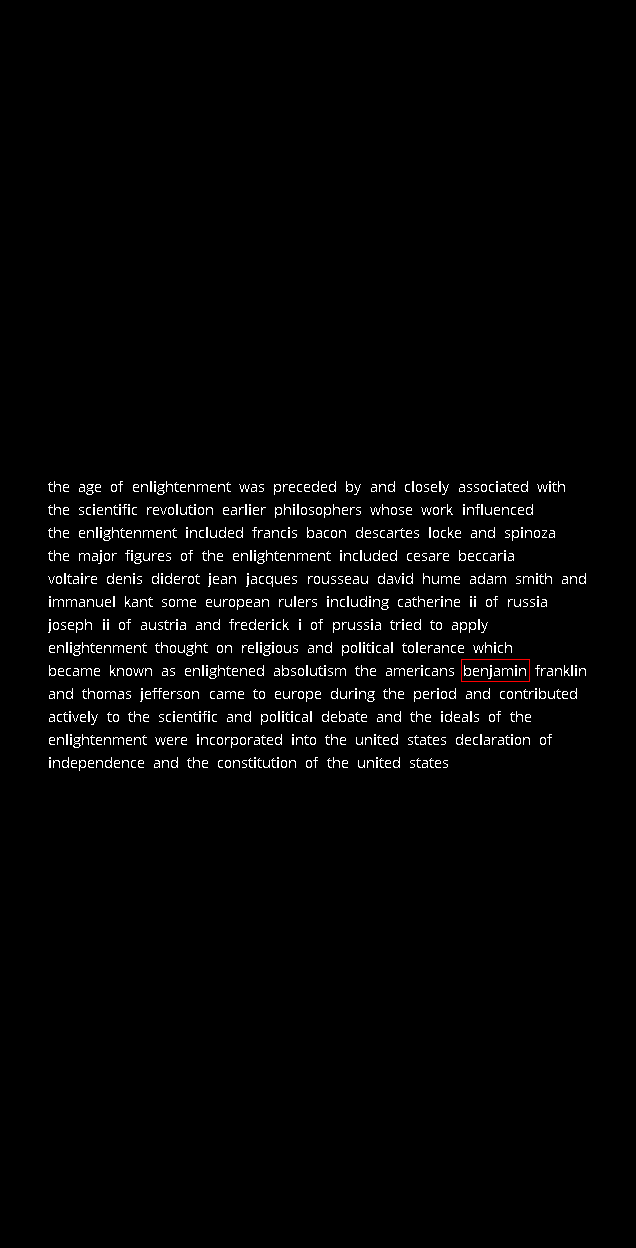

In [47]:
show_bounding_box(img, ann["benjamin"][0], spread=2)